# Predicting tags for the given code
### Using simple models (SVM, LogReg, Naive Bayes, LGBM)

In [2]:
# !pip install dagshub

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

import pickle
import dagshub

In [4]:
def load_code_blocks(DATASET_PATH, CODE_COLUMN):
    df = pd.read_csv(DATASET_PATH, encoding='utf-8', comment='#', sep='\t')#, quoting=csv.QUOTE_NONE, error_bad_lines=False)#, sep=','
    print("Data of {} shape has been loaded".format(df.shape))
    print(df.columns)
    code_blocks = df[CODE_COLUMN]
    # test_size = 0.1
    # test_rows = round(df.shape[0]*test_size)
    # train_rows = df.shape[0] - test_rows
    # train_code_blocks = df[CODE_COLUMN][0:test_rows]
    # test_code_blocks = df[CODE_COLUMN][train_rows:]
    return df, code_blocks

In [5]:
def tfidf_fit_transform(code_blocks, params, TFIDF_DIR):
    vectorizer = TfidfVectorizer(params)
    tfidf = vectorizer.fit(code_blocks)
    pickle.dump(tfidf, open("tfidf.pickle", "wb"))
    code_blocks_tfidf = tfidf.transform(code_blocks)
    print("tfidf trained, saved and transformed")
    return code_blocks_tfidf

In [6]:
def tfidf_transform(code_blocks, params, TFIDF_DIR):
    tfidf = pickle.load(open(TFIDF_DIR, 'rb'))
    code_blocks_tfidf = tfidf.transform(code_blocks)
    print("tfidf loaded and transformed")
    return code_blocks_tfidf

In [7]:
def SVM_evaluate(df, code_blocks, tfidf_params, TFIDF_DIR, SVM_params):
    code_blocks_tfidf = tfidf_fit_transform(code_blocks, tfidf_params, TFIDF_DIR)
    X_train, X_test, y_train, y_test = train_test_split(code_blocks_tfidf, df[TAG_TO_PREDICT], test_size=0.3)
    # grid = {"C": [100]}
    # cv = KFold(n_splits=2, shuffle=True, random_state=241)
    # model = SVC(kernel="linear", random_state=241)
    # gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=-1)
    # gs.fit(X_train[:25000], y_train.ravel()[:25000])
    # C = gs.best_params_.get('C')
    model = SVC(**SVM_params)
    # model.set_params(SVM_params)
    print(model.get_params())
    model.fit(X_train, y_train.ravel())
    # a faster option:
    # 1: usage of BagginClassifier decreased the fitting time from 38 mins to 8
    # n_estimators = 10
    clf = model
    # clf = BaggingClassifier(model, max_samples=1.0 / n_estimators, n_estimators=n_estimators)
    # clf.fit(X_train, y_train.ravel())
    pickle.dump(clf, open(MODEL_DIR, 'wb'))
    # y_pred = model.predict(X_test)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics = {'test_accuracy': accuracy
               , 'test_f1_score': f1}
    plot_confusion_matrix(model, X_test, y_test)
    return metrics

In [21]:
def get_predictions(X, y, TAG_TO_PREDICT, MODEL_DIR):
    clf = pickle.load(open(MODEL_DIR, 'rb'))
    print("the model has been loaded")
    # result = loaded_model.score(X, y)
    y_pred = clf.predict(X)
    print("predictions were calculated")
    accuracy = clf.score(X, y)
    f1 = f1_score(y_pred, y, average='weighted')
    print(f'Mean Accuracy {round(accuracy*100, 2)}%')
    print(f'F1-score {round(f1*100, 2)}%')
    errors = y - y_pred
    plt.hist(errors)
    plot_precision_recall_curve(clf, X, y)
    plot_confusion_matrix(clf, X, y, values_format='d')
    def mean_confidence_interval(data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h
    conf_interval = mean_confidence_interval(errors, 0.95)
    print(conf_interval)
    metrics = {'test_accuracy': accuracy
               , 'test_f1_score': f1
               , 'conf_interval': conf_interval}
    return X, y, y_pred, metrics
    print(result)

### Predictions and Logging

In [18]:
# if __name__ == '__main__':
#     DATASET_PATH = './data/chunks_5_validate.csv'
#     MODEL_DIR = './models/svm_regex_graph_v2.1.sav'
#     TFIDF_DIR = './models/tfidf_svm_graph_v2.1.pickle'
#     CODE_COLUMN = 'code' #'code_block'
#     TAG_TO_PREDICT = 'tag' #'preprocessing'
#     SCRIPT_DIR = 'predict_tag.ipynb'

#     df, code_blocks = load_code_blocks(DATASET_PATH, CODE_COLUMN)
#     nrows = df.shape[0]
#     print("loaded")
#     tfidf_params = {'min_df': 5
#             , 'max_df': 0.3
#             , 'smooth_idf': True}
#     SVM_params = {'C': 100
#             , 'kernel': "linear"
#             , 'verbose': 1
#             , 'random_state': 241}
#     meta = {'data': DATASET_PATH
#                 ,'nrows': nrows
#                 ,'label': TAG_TO_PREDICT
#                 ,'model': MODEL_DIR
#                 ,'script_dir': SCRIPT_DIR}

#     code_blocks_tfidf = tfidf_transform(code_blocks, tfidf_params, TFIDF_DIR)
#     with dagshub.dagshub_logger() as logger:
#         # metrics = SVM_evaluate(df, code_blocks, tfidf_params, TFIDF_DIR, SVM_params)
#         _, _, _, metrics = get_predictions(code_blocks_tfidf, df[TAG_TO_PREDICT].astype(int), TAG_TO_PREDICT, MODEL_DIR)
#         logger.log_hyperparams(meta)
#         logger.log_hyperparams(tfidf_params)
#         logger.log_hyperparams(SVM_params)
#         logger.log_metrics(metrics)
#     print("finished")

### Validation (different chunk_sizes)

Data of (1125, 2) shape has been loaded
Index(['code', 'tag'], dtype='object')
loaded
tfidf loaded and transformed
tfidf-ed
the model has been loaded
predictions were calculated
Mean Accuracy 55.82%
F1-score 65.45%
(0.37066666666666664, 0.3383784727400161, 0.4029548605933172)
finished
Data of (562, 2) shape has been loaded
Index(['code', 'tag'], dtype='object')
loaded
tfidf loaded and transformed
tfidf-ed
the model has been loaded
predictions were calculated
Mean Accuracy 55.34%
F1-score 62.71%
(0.32562277580071175, 0.27722560685814956, 0.37401994474327394)
finished
Data of (374, 2) shape has been loaded
Index(['code', 'tag'], dtype='object')
loaded
tfidf loaded and transformed
tfidf-ed
the model has been loaded
predictions were calculated
Mean Accuracy 57.22%
F1-score 63.12%
(0.2994652406417112, 0.2402619629915388, 0.3586685182918836)
finished
Data of (280, 2) shape has been loaded
Index(['code', 'tag'], dtype='object')
loaded
tfidf loaded and transformed
tfidf-ed
the model has been l

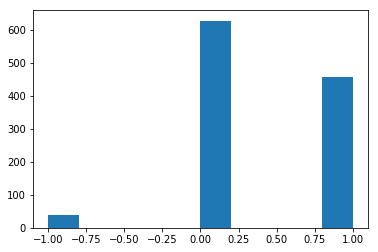

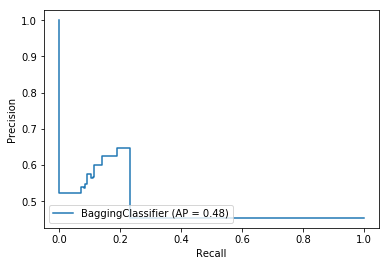

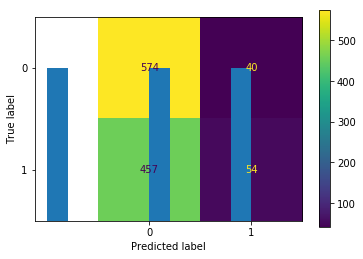

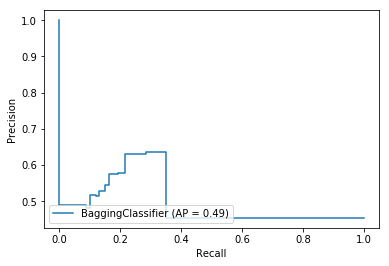

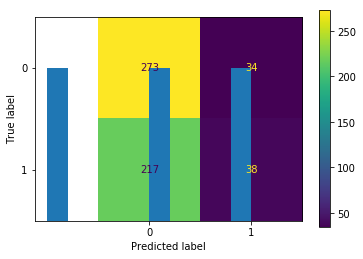

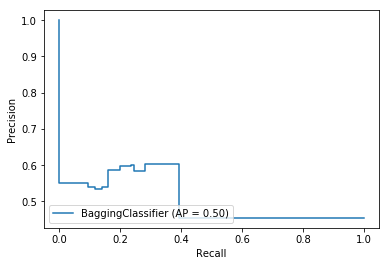

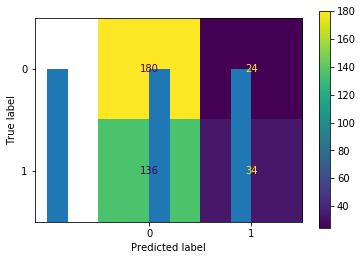

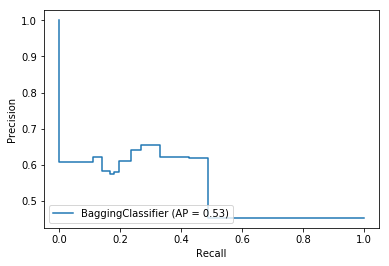

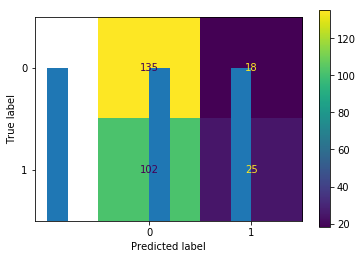

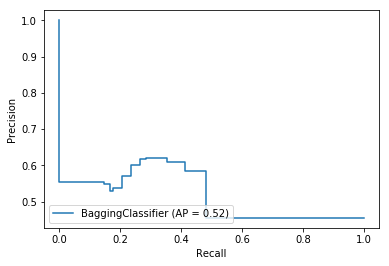

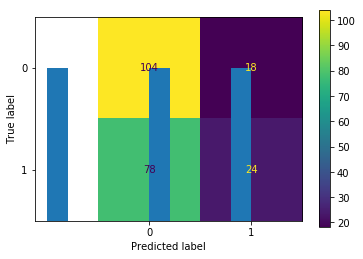

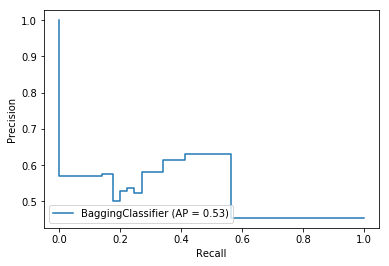

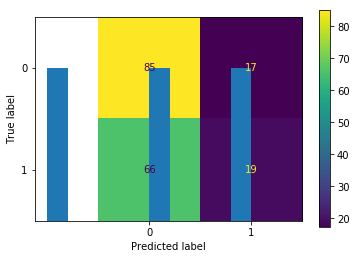

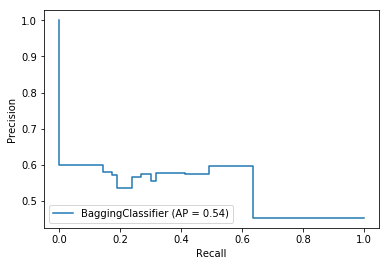

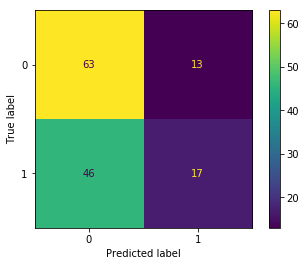

In [15]:
if __name__ == '__main__':
    all_metrics = []
    chunk_sizes = [5, 10, 15, 20, 25, 30, 40]
    for i in chunk_sizes:
        GRAPH_VER = 2.2
        MODEL = 'svm'
        DATASET_PATH = './data/chunks_{}_validate.csv'.format(i)
        MODEL_DIR = './models/{}_regex_graph_v{}.sav'.format(MODEL, GRAPH_VER)
        TFIDF_DIR = './models/tfidf_{}_graph_v{}.pickle'.format(MODEL, GRAPH_VER)
        CODE_COLUMN = 'code'
        TAG_TO_PREDICT = 'tag'
        df, corpus = load_code_blocks(DATASET_PATH, CODE_COLUMN)
        nrows = df.shape[0]
        print("loaded")
        params = {'min_df': 5
                , 'max_df': 0.3
                , 'smooth_idf': True}
        data_meta = {'DATASET_PATH': DATASET_PATH
                    ,'nrows': nrows
                    ,'label': TAG_TO_PREDICT
                    ,'model': 'Logistic Regression'}
        features = tfidf_transform(corpus, params, TFIDF_DIR)
        print("tfidf-ed")
        # metrics = logreg_evaluate(df, features, TAG_TO_PREDICT)
        _, _, _, metrics = get_predictions(features, df[TAG_TO_PREDICT], TAG_TO_PREDICT, MODEL_DIR)
        all_metrics.append(metrics)
        # with dagshub.dagshub_logger() as logger:
        #     logger.log_hyperparams(data_meta)
        #     logger.log_hyperparams(params)
        #     logger.log_metrics(metrics)
        print("finished")

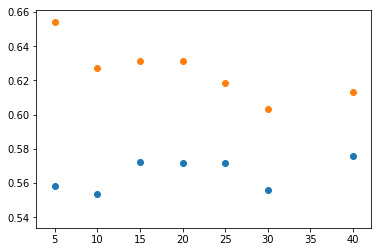

In [16]:
all_acc = [all_metrics[i]['test_accuracy'] for i in range(len(all_metrics))]
all_f1 = [all_metrics[i]['test_f1_score'] for i in range(len(all_metrics))]
plt.scatter(chunk_sizes, all_acc)
plt.scatter(chunk_sizes, all_f1)

## Errors Analysis

In [37]:
GRAPH_VER = 2.2
MODEL = 'logreg'
CHUNK_SIZE = 10
CODE_COLUMN = 'code'
TAG_TO_PREDICT = 'tag'

DATASET_PATH = './data/chunks_{}_validate.csv'.format(CHUNK_SIZE)
MODEL_DIR = './models/{}_regex_graph_v{}.sav'.format(MODEL, GRAPH_VER)
TFIDF_DIR = './models/tfidf_{}_graph_v{}.pickle'.format(MODEL, GRAPH_VER)
df, corpus = load_code_blocks(DATASET_PATH, CODE_COLUMN)
nrows = df.shape[0]
print("loaded")
params = {'min_df': 5
        , 'max_df': 0.3
        , 'smooth_idf': True}
data_meta = {'DATASET_PATH': DATASET_PATH
            ,'nrows': nrows
            ,'label': TAG_TO_PREDICT
            ,'model': 'Logistic Regression'}
features = tfidf_transform(corpus, params, TFIDF_DIR)
print("tfidf-ed")

Data of (562, 2) shape has been loaded
Index(['code', 'tag'], dtype='object')
loaded
tfidf loaded and transformed
tfidf-ed


the model has been loaded
predictions were calculated
Mean Accuracy 58.19%
F1-score 62.16%
(0.24733096085409254, 0.19778312765498818, 0.2968787940531969)


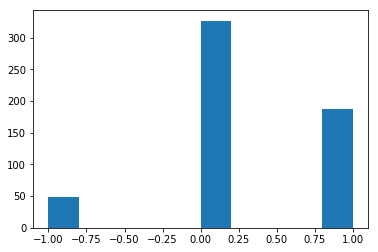

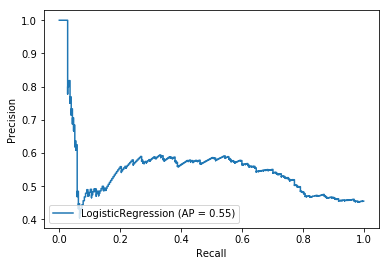

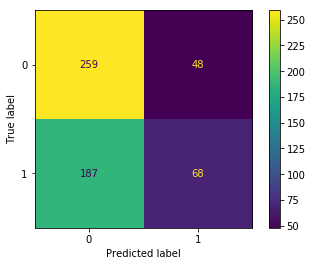

In [38]:
_, y, y_pred, _ = get_predictions(features, df[TAG_TO_PREDICT], TAG_TO_PREDICT, MODEL_DIR)

In [39]:
pd.set_option('max_colwidth', 500)
pd.set_option('max_rows', 500)

In [40]:
## False Negatives (preprocessing y/n)
corpus[(y_pred-y)==-1].reset_index(drop=True)[:]

oat32)\r\nstd_px = X_train.std().astype(np.float32)\r\n\r\ndef standardize(x): \r\n    return (x-mean_px)/std_px\ndef get_image_file_path(image_file_name):\r\n    """returns the path of image file"""\r
148              def get_images(n):\n    """reads all the files from `../input/test` directory and returns paths for n files from top"""\n    all_image_files = os.listdir("../input/test/")\n    # let's save all these Path (image)s for later\n    image_paths = list(map(get_image_file_path, all_image_files))\n    # rather than using all, we will use a subset of these Path (image)s for working on our model\n    image_paths = image_paths[:n]\n    return image_paths\ndef get_image_id_from_path(image_path):
149                                      return image_path.split('../input/test/')[1].split('.jpg')[0]\ndef show_image_by_index(i):\n    sample_image = plt.imread(f'../input/test/{test_filename[i]}')\n    plt.imshow(sample_image)\ndef show_image_by_filename(filename):\r\n    sample_image = 

In [41]:
## False Positives (preprocessing y/n)
corpus[(y_pred-y)==1].reset_index(drop=True)[:]

7)]\ndel d[key]\n{i: a[i] for i in a if (i != 0)}\nlol.pop('hello')\ndel r[key]\nnp.linalg.solve(np.dot(a.T, a), np.dot(a.T, b))\npd.concat([df.drop('b', axis=1), pd.DataFrame(df['b'].tolist())], axis=1)\nfor i in range(0, 10, 2):\n    pass
9                                                                                                                                                              pass\n[{'content': x['content'].lower()} for x in messages]\n""" """.join(my_list)\nre.sub('(http://\\S+|\\S*[^\\w\\s]\\S*)', '', a)\nstr(n) == str(n)[::-1]\nftp.storbinary('STOR myfile.txt', open('myfile.txt', 'rb'))\nre.sub('.*I', 'I', stri)\nint('1,000,000'.replace(',', ''))\npd.merge(df1, df2, left_index=True, right_index=True, how='outer')
10                                                                                                                                'Hello\n\n\n'.rstrip('\n')\nre.findall('.{,16}\\b', text)\n[[X[i][j] for j in range(len(X[i]))] for i in range(len(X))]\n'\

In [42]:
## True (preprocessing y/n)
corpus[(y_pred-y)==0].reset_index(drop=True)[:]

s[0])\n{k: [d[k] for d in dicts] for k in dicts[0]}\nrequest.args['myParam']\n[k for k, v in list(Counter(mylist).items()) if v > 1]\nsys.path.insert(1, os.path.join(os.path.dirname(__file__), 'apps'))
288                                                                                                db.execute("INSERT INTO present VALUES('test2', ?, 10)", (None,))\n[image for menuitem in list_of_menuitems for image in menuitem]\na.extend(b)\na.extend(list(b))\nnp.savetxt('c:\\data\\np.txt', df.values, fmt='%d')\ndf.to_csv('c:\\data\\pandas.txt', header=None, index=None, sep=' ', mode='a')\nprint(x.rpartition('-')[0])\nprint(x.rsplit('-', 1)[0])\nftp.storlines('STOR ' + filename, open(filename, 'r'))
289                                                                                                                                                                                                                                              np.maximum([2, 3, 4], [1, 5, 2])\nprint(l[3:] + l[